In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('datasets/train.csv')
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
df.shape

(595212, 59)

In [4]:
# Because the document said values of -1 indicate that the feature was missing from the observation. 
# We need to delete those data
df = df[(df == -1).any(axis=1)]

Class 0: 454257
Class 1: 16024
Proportion: 28.35 : 1


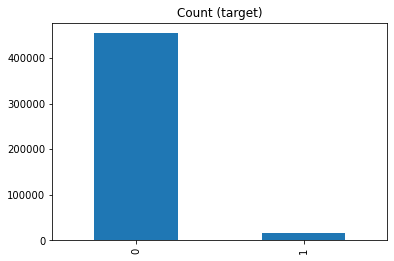

In [5]:
## Let's see how unbalanced the dataset is
target_count = df.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [6]:
# Split X and y
X = df.drop('target', axis=1).copy()
y = df['target'].copy()

In [7]:
# # Split training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
from sklearn.preprocessing import scale
# Scale
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [11]:
# Build Logistc Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# L1 penalty
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=0)

# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100]

# Create hyperparameter options
hyperparameters = dict(C=C)

# Create grid search using 5-fold cross validation
grid_search = GridSearchCV(logreg_l1, hyperparameters, cv=5, verbose=1, scoring='roc_auc', n_jobs=4)

grid_result = grid_search.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   40.9s finished


Best: 0.618276 using {'C': 0.01}


In [12]:
## It turns out our best parameter is 0.01
clf_lr = LogisticRegression(penalty='l1', solver='liblinear', C=0.01, random_state=0)
clf_lr.fit(X_train_scaled, y_train)

LogisticRegression(C=0.01, penalty='l1', random_state=0, solver='liblinear')

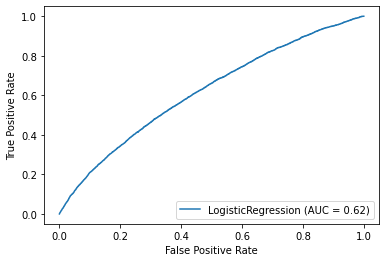

In [13]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(clf_lr, X_test_scaled, y_test) 

In [14]:
# ## Compute area under precision-recall curve (AUPRC)
# from sklearn.metrics import auc
# from sklearn.metrics import precision_recall_curve
# lr_probs = clf_lr.predict_proba(X_test_scaled)
# lr_probs = lr_probs[:, 1]
# lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
# fir_auc_score = auc(lr_recall, lr_precision)
# print(fir_auc_score)

0.0540069215535254


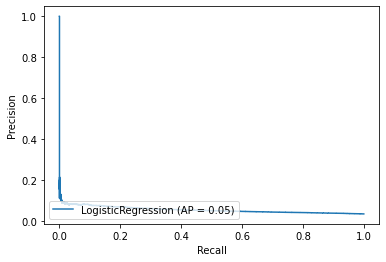

In [15]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(clf_lr, X_test_scaled, y_test) 

In [19]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_resample(X_train, y_train)

In [20]:
X_train_new = scale(os_data_X)
y_train_new = os_data_y

In [21]:
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['target'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of 0 in oversampled data",len(os_data_y[os_data_y['target']==0]))
print("Number of 1",len(os_data_y[os_data_y['target']==1]))
print("Proportion of 0 data in oversampled data is ",len(os_data_y[os_data_y['target']==0])/len(os_data_X))
print("Proportion of 1 data in oversampled data is ",len(os_data_y[os_data_y['target']==1])/len(os_data_X))

length of oversampled data is  635876
Number of no subscription in oversampled data 317938
Number of subscription 317938
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [24]:
# Build Logistc Regression Model
grid_search = GridSearchCV(logreg_l1, hyperparameters, cv=5, verbose=1, scoring='roc_auc', n_jobs=4)
grid_result = grid_search.fit(X_train_new, y_train_new)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 15.9min finished


Best: 0.970406 using {'C': 0.1}


In [25]:
## It turns out our best parameter is 0.1
clf_lr_after = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=0)
clf_lr_after.fit(X_train_new, y_train_new)

LogisticRegression(C=0.1, penalty='l1', random_state=0, solver='liblinear')

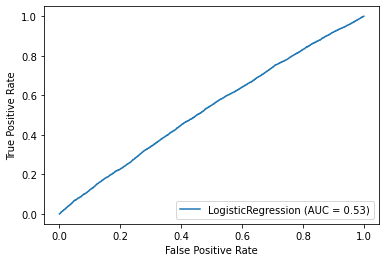

In [26]:
plot_roc_curve(clf_lr_after, X_test_scaled, y_test)

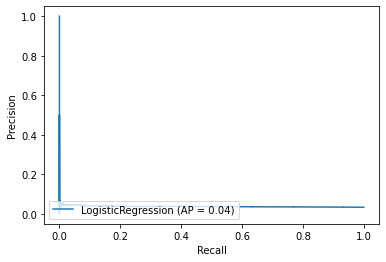

In [27]:
plot_precision_recall_curve(clf_lr_after, X_test_scaled, y_test) 

In [ ]:
# target_count = df.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

# Changing ratio

In [28]:
from sklearn.metrics import roc_auc_score

In [29]:
def score_diff(df, y_name, ratio=None):
    
    """
    This function return the difference of percentage of auc score before and after oversampling using SMOTE.
    """
    assert type(y_name) == str, 'y_name must be a string'
    
    if ratio == None:
        df_new = df
    else:
        from sklearn.utils import resample

        df_0 = df[df[y_name] == 0]
        df_1 = df[df[y_name] == 1]

        # oversample df_1
        frac = df_0.shape[0] / (ratio * df_1.shape[0])
        df_0_new = df_0
        df_1_new = df_1.sample(frac=frac, random_state=0)
        
        print('The ratio of the dataset is', df_0_new.shape[0]/df_1_new.shape[0],':1')
    
        df_new = pd.concat([df_0_new, df_1_new])
    
    # Split X and y
    X = df_new.drop(y_name, axis=1)
    y = df_new[y_name]
    
    # Split training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    # Scale
    X_train_scaled = scale(X_train)
    X_test_scaled = scale(X_test)
    
    # Hyperparamter tuning
    logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=0)

    # Create regularization hyperparameter space
    C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

    # Create hyperparameter options
    hyperparameters = dict(C=C)

    # Create grid search using 5-fold cross validation
    grid_search = GridSearchCV(logreg_l1, hyperparameters, cv=5, verbose=1, scoring='roc_auc', n_jobs=-1)

    grid_result = grid_search.fit(X_train_scaled, y_train)
    
    best_C = grid_result.best_params_.get('C')
    print(best_C)
    
    # Build model before oversampling
    clf_lr = LogisticRegression(penalty='l1', solver='liblinear', C=best_C)
    clf_lr.fit(X_train_scaled, y_train)
    
    # Compute first auc score
    fir_auc_score = roc_auc_score(y_test, clf_lr.decision_function(X_test_scaled))
    print(fir_auc_score)
    
    # Oversampling
    os = SMOTE(random_state=0)

    X_train_new, y_train_new=os.fit_resample(X_train, y_train)
    
    X_train_scaled_new = scale(X_train_new)
    
    # hyperparameter_tuning
    grid_result_new = grid_search.fit(X_train_scaled_new, y_train_new)
    
    best_C_new = grid_result_new.best_params_.get('C')
    print(best_C_new)
    
    # Build model after oversampling
    clf_lr_after = LogisticRegression(penalty='l1', solver='liblinear', C=best_C_new)
    clf_lr_after.fit(X_train_scaled_new, y_train_new)
    
    # Compute second auc score
    secon_auc_score = roc_auc_score(y_test, clf_lr_after.decision_function(X_test_scaled))
    print(secon_auc_score)
    
    return (secon_auc_score - fir_auc_score) 



In [31]:
score_diff(df, 'target', 50)

The ratio of the dataset is 50.00077050082554 :1
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  5.4min finished


0.01
0.619556739989838
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 13.4min finished


1000
0.5352469305256403


-0.08430980946419764

In [32]:
score_diff(df, 'target', 100)

The ratio of the dataset is 99.99053488883997 :1
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  3.3min finished


0.01
0.6209834628516866
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 13.3min finished


0.1
0.5435923318595565


-0.07739113099213013

# Changing features numbers to 2

In [33]:
df = pd.read_csv('https://raw.githubusercontent.com/johnmyleswhite/ML_for_Hackers/master/02-Exploration/data/01_heights_weights_genders.csv')
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [34]:
df = pd.get_dummies(df, 'Gender')
df = df.drop('Gender_Female', axis=1)
df.head()

,Height,Weight,Gender_Male
0,73.847017,241.893563,1
1,68.781904,162.310473,1
2,74.110105,212.740856,1
3,71.730978,220.042470,1
4,69.881796,206.349801,1


In [36]:
score_diff(df, 'Gender_Male', 50)

The ratio of the dataset is 50.0 :1
Fitting 5 folds for each of 7 candidates, totalling 35 fits
0.01
0.9620265641556394
Fitting 5 folds for each of 7 candidates, totalling 35 fits
1
0.9653286020551489


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.0s finished


0.003302037899509558

In [37]:
score_diff(df, 'Gender_Male', 100)

The ratio of the dataset is 100.0 :1
Fitting 5 folds for each of 7 candidates, totalling 35 fits
100
0.9571428571428571
Fitting 5 folds for each of 7 candidates, totalling 35 fits
1
0.9609302325581396


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.0s finished


0.0037873754152825123